In [1]:
# Imports
import torch
import os 
import sys
from dask_jobqueue import SLURMCluster
from distributed import Client
from pathlib import Path

import do_simulation_causalklgp_discrete as file

In [2]:
# Args setup
ntrial = 100
n = 100
n_int = 2
niter = 1000
front_door = False
minimise =  True
calibrate = True
sample_split = True
add_base_kernel_BO = True

In [3]:
# Cluster creation
cluster = SLURMCluster(
    n_workers=0,
    memory="32GB",
    processes=1,
    cores=1,
    scheduler_options={
        "dashboard_address": ":11111",
        "allowed_failures": 10
    },
    job_cpu=1,
    walltime="3:0:0",
    
    job_extra_directives = ["-p medium,fast,cpu"],
)
cluster.adapt(minimum=0, maximum=200)
client = Client(cluster)

In [4]:
# Submitting jobs
futures = []
for seed in range(ntrial):
        f = client.submit(file.main,
                              seed,
                              n,n_int,
                              niter = niter,
                              front_door = front_door,
                              minimise = minimise,
                              calibrate = calibrate,
                              sample_split = sample_split,
                              add_base_kernel_BO = add_base_kernel_BO
                             )
        futures += [f]

In [5]:
futures

[<Future: pending, key: main-bd8466bc8d8589f3b32fa0643740a745>,
 <Future: pending, key: main-a70942eaf5842e3728c6cbec53a96af0>,
 <Future: pending, key: main-563e46c797dcb3e1afb4386bc6496030>,
 <Future: pending, key: main-377b2803629319302729e093d29d81ac>,
 <Future: pending, key: main-e1e6f78cb0f43951242377199114c79b>,
 <Future: pending, key: main-f0d68a0d9649d7d6eb45930129754665>,
 <Future: pending, key: main-22ac38d1da391d7551d12ec20f6322e3>,
 <Future: pending, key: main-513ceabd7227d9cfefbe72ac7dd59941>,
 <Future: pending, key: main-87f608c624699f655658ec913cedb146>,
 <Future: pending, key: main-47bdd3c4a1a629a1f0bf80643121bd80>,
 <Future: pending, key: main-3064cd4e48e0199bc87656f269c2c76c>,
 <Future: pending, key: main-793a41ce832e4d85abd43a8941ea2242>,
 <Future: pending, key: main-ac93b7a081372ce4c8c22188d228a7f1>,
 <Future: pending, key: main-285a3fc3279645dfacf6dc8c528b5825>,
 <Future: pending, key: main-8d84071aec41d4cd5433df96867fdf3b>,
 <Future: pending, key: main-14fdd402282

In [6]:
# Getting results
results = client.gather(futures)

In [7]:
# Closing client
client.close()
cluster.close()

In [8]:
mean = torch.zeros(ntrial)
se = torch.zeros(ntrial)
nlevel = len(results[0]['post_levels'])
fracs = torch.zeros((ntrial,nlevel))
for i in range(ntrial):
    mean[i] = results[i]['post_moments'][0]
    se[i] =  results[i]['post_moments'][1]**0.5
    fracs[i] =  results[i]['post_levels']
((0 <= (mean + 1.965*se) ) * (0 >= (mean - 1.965*se))).float().mean()

tensor(0.9600)

In [14]:
fracs.mean(0)

tensor([0.8200, 0.9400, 0.9600])

In [20]:
mean.abs().mean(),mean.abs().std()

(tensor(0.1558), tensor(0.2061))

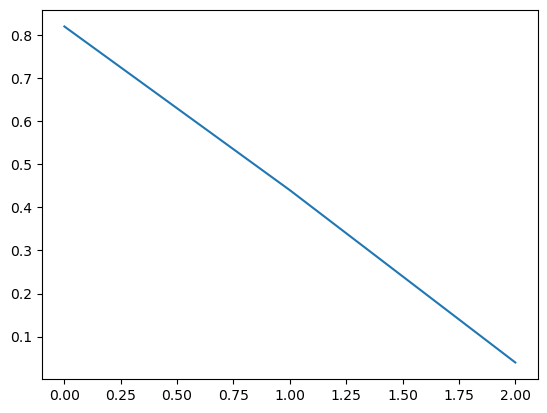

In [12]:
import matplotlib.pyplot as plt
import torch
plt.plot((torch.linspace(0,1,nlevel)-fracs.mean(0)).abs())

In [15]:
# Saving results
torch.save(obj = results,
           f = "simulation_causalklgp_ntrial={0}_n={1}_frontdoor={2}_discrete.pt".format(ntrial,
                                                                                             n,
                                                                                             front_door)
          )